# Getting started with treedata

{class}`treedata.TreeData` is a lightweight wrapper around {class}`anndata.AnnData` which adds two additional attributes, `obst` and `vart`, 
to store trees for observations and variables. This tutorial will walk you through the basic usage of `TreeData`, including how to create, 
subset, and manipulate `TreeData` objects. If you want to learn more about how `TreeData` used to analyze single-cell lineage tracing data 
check out the Pycea [getting started tutorial](https://pycea.readthedocs.io/en/latest/notebooks/getting-started.html).

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import scanpy as sc
import treedata as td
import matplotlib.pyplot as plt
import random

In [2]:
def plot_tree(tree, color_attr=None):
    """Helper function for plotting trees."""
    plt.figure(figsize=(6, 3))
    node_colors = "lightgrey" if color_attr is None else [tree.nodes[node].get(color_attr) for node in tree.nodes()]
    pos = nx.drawing.nx_agraph.graphviz_layout(tree, prog="dot")
    nx.draw(tree, pos, with_labels=False, node_size=100, node_color=node_colors)
    leaf_nodes = [node for node in tree.nodes() if tree.out_degree(node) == 0]
    for node, (x, y) in pos.items():
        if node in leaf_nodes:
            plt.text(x, y + 10, s=node, rotation=90, fontsize=6, ha="center", va="top")
        else:
            plt.text(x, y, s=node, fontsize=6, ha="center", va="center")
    plt.show()

## Initializing TreeData

A `TreeData` object is initialized just like an `AnnData` object. Let's create a `TreeData` object with 32 cells and 100 genes. 

In [3]:
counts = pd.DataFrame(
    np.random.normal(size=(32, 100)),
    index=[f"Cell_{i:d}" for i in range(32)],
    columns=[f"Gene_{i:d}" for i in range(100)],
)
tdata = td.TreeData(counts)
tdata

TreeData object with n_obs × n_vars = 32 × 100

Now, suppose we have an `nx.DiGraph` tree representing relationships between cells, perhaps from a lineage tracing experiment

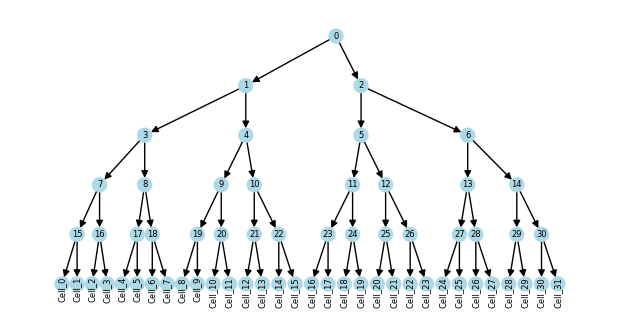

In [4]:
tree = nx.balanced_tree(r=2, h=5, create_using=nx.DiGraph)
leaves = [i for i in tree.nodes if tree.out_degree(i) == 0]
tree = nx.relabel_nodes(tree, {j: f"Cell_{i}" for i, j in enumerate(leaves)})
nx.set_node_attributes(tree, "lightblue", "color")
plot_tree(tree, "color")

We can store this tree in the `obst` attribute of the `TreeData` object

In [5]:
tdata.obst["lineage"] = tree
tdata

TreeData object with n_obs × n_vars = 32 × 100
    obs: 'tree'
    obst: 'lineage'

The `obs` dataframe now contains a column with tree membership

In [6]:
tdata.obs.head()

,tree
Cell_0,lineage
Cell_1,lineage
Cell_2,lineage
Cell_3,lineage
Cell_4,lineage


A `TreeData` object can also be initialized with only the tree

In [7]:
td.TreeData(obst={"lineage": tree})

TreeData object with n_obs × n_vars = 32 × 0
    obs: 'tree'
    obst: 'lineage'

Or with only the tree and associated observation data

In [8]:
obs = pd.DataFrame({"cluster": np.random.randint(0, 5, size=32)}, index=[f"Cell_{i:d}" for i in range(32)])
td.TreeData(obst={"lineage": tree}, obs=obs)

TreeData object with n_obs × n_vars = 32 × 0
    obs: 'cluster', 'tree'
    obst: 'lineage'

## Subsetting TreeData

Similar to `AnnData`, we can subset `TreeData` along the `obs` and `var` axes, which provides a view of the `TreeData` object.

In [9]:
tdata_subset = tdata[["Cell_0", "Cell_1", "Cell_2", "Cell_10"], ["Gene_5", "Gene_19"]]
tdata_subset

View of TreeData object with n_obs × n_vars = 4 × 2
    obs: 'tree'
    obst: 'lineage'

Just like `obs` and `obsm` annotations, the trees stored in `obst` are subset along with the data. Specifically, a subtree is created with the selected leaves and their ancestors.

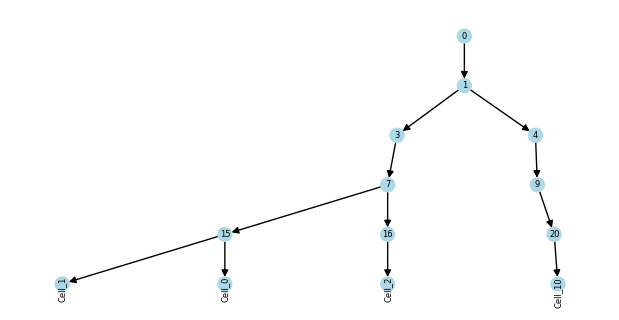

In [10]:
plot_tree(tdata_subset.obst["lineage"], "color")

Since the subtree is a view of the original tree, changes to node attributes in the subtree will be reflected in the original tree.

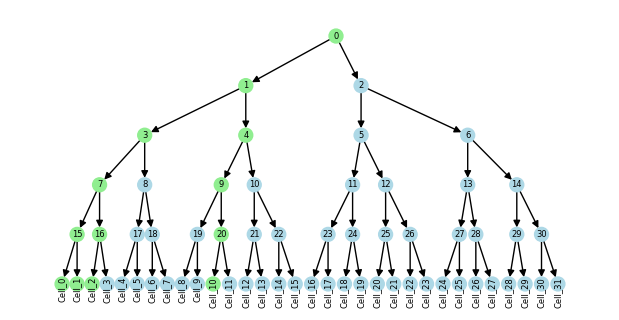

In [11]:
nx.set_node_attributes(tdata_subset.obst["lineage"], "lightgreen", "color")
plot_tree(tdata.obst["lineage"], "color")

## Views and copies

`TreeData` views such as `tdata_subset` store a reference to the original data

In [12]:
tdata_subset = tdata[:20, :]
tdata_subset

View of TreeData object with n_obs × n_vars = 20 × 100
    obs: 'tree'
    obst: 'lineage'

If we want a `TreeData` object with its own copy of the data, we can use the `copy` method.

In [13]:
tdata_subset.copy()

TreeData object with n_obs × n_vars = 20 × 100
    obs: 'tree'
    obst: 'lineage'

If we add new data to `tdata_subset`, it can no longer be a reference to `tdata`, so it auto-copies generating a data-storing object.

In [14]:
tdata_subset.obs["foo"] = "bar"
tdata_subset

/var/folders/qd/nvzjj6dd3bx9d0pqsk7m4tr80000gn/T/ipykernel_25346/2560538419.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tdata_subset.obs["foo"] = "bar"


TreeData object with n_obs × n_vars = 20 × 100
    obs: 'tree', 'foo'
    obst: 'lineage'

The toplogy of trees stored in `obst` and `vart` is frozen so you cannot add/remove nodes or edges. However, you can change node attributes. 

In [15]:
try:
    tdata.obst["lineage"].remove_node("Cell_0")
except nx.NetworkXError as e:
    print(e)
tdata.obst["lineage"].nodes["Cell_1"]["color"] = "plum"

Frozen graph can't be modified


If you need to change the topology of the tree, you can create a copy, modify the tree, and then assign it back to the `obst` attribute.

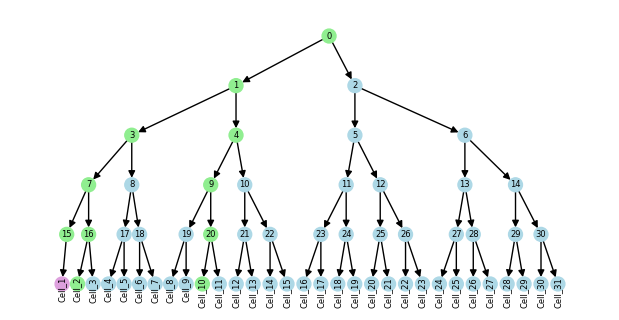

In [16]:
tree = tdata.obst["lineage"].copy()
tree.remove_node("Cell_0")
tdata.obst["lineage"] = tree
plot_tree(tdata.obst["lineage"], "color")

## Multiple trees

`TreeData` can store multiple observation and variable trees in the `obst` and `vart` attributes. As an example, we'll create two variable trees which could represent a hierarchical clustering of genes.

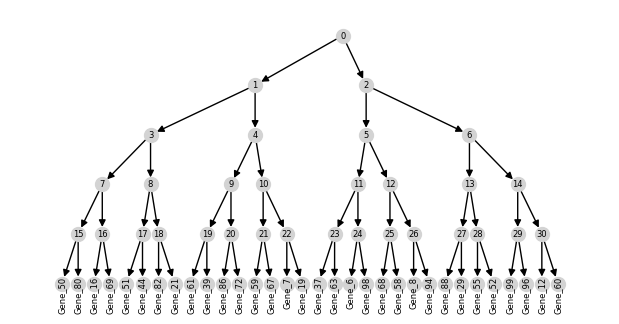

In [17]:
tree = nx.balanced_tree(r=2, h=5, create_using=nx.DiGraph)
genes_1 = random.sample(list(tdata.var_names), 32)
genes_2 = random.sample(list(tdata.var_names), 32)
tree_1 = nx.relabel_nodes(tree.copy(), {i + 31: j for i, j in enumerate(genes_1)})
tree_2 = nx.relabel_nodes(tree.copy(), {i + 31: j for i, j in enumerate(genes_2)})
plot_tree(tree_1)

We'll store these trees in `vart` as `"clustering_1"` and `"clustering_2"`

In [18]:
tdata.vart["clustering_1"] = tree_1
tdata.vart["clustering_2"] = tree_2

The `tree` column in the `var` dataframe now contains a list of tree memberships with some genes belonging to both trees.

In [19]:
tdata.var["tree"].value_counts()

tree
clustering_2                 22
clustering_1                 22
clustering_1,clustering_2    10
Name: count, dtype: int64

To dissallow overlapping trees, you can set the `allow_overlap` parameter to `False`.

In [20]:
del tdata.vart["clustering_2"]
tdata.allow_overlap = False
try:
    tdata.vart["clustering_2"] = tree_2
except ValueError as e:
    print(e)

Leaf names overlap with leaf names of other trees. Set `allow_overlap=True` to allow this.


## Alignment

By default, `obs_names` and `var_names` are aligned to the leaves of trees stored in `obst` and `vart`. However, `TreeData` supports multiple alignment types which can be declared using the `alignment` parameter. See the [Alignment](https://treedata.readthedocs.io/en/latest/notebooks/concatenation.html) tutorial for more details.

For example, we can create a `TreeData` object with `alignment='nodes'` where all nodes in the tree are observed instead of just the leaves.

In [21]:
tree = nx.balanced_tree(r=2, h=5, create_using=nx.DiGraph)
tree = nx.relabel_nodes(tree, {i: str(i) for i in tree.nodes()})
nodes_tdata = td.TreeData(obs=pd.DataFrame(index=tree.nodes()), obst={"lineage": tree}, alignment="nodes")
nodes_tdata

TreeData object with n_obs × n_vars = 63 × 0
    obs: 'tree'
    obst: 'lineage'

## Scverse integration

Since the `TreeData`object has the same interface as the `AnnData` object, it can be used anywhere `AnnData` is used, including with `scverse` packages like `scanpy` and `squidpy`.

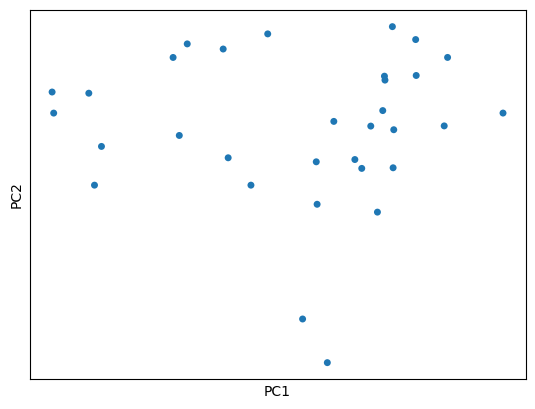

In [22]:
sc.tl.pca(tdata, svd_solver="arpack")
sc.pl.pca(tdata, size=100, na_color="tab:blue")

And if you ever need to convert a `TreeData` object to an `AnnData` object, you can use the `to_adata` method.

In [23]:
adata = tdata.to_adata()
adata

AnnData object with n_obs × n_vars = 32 × 100
    obs: 'tree'
    var: 'tree'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'